In [1]:
# Import necessary librarires
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

# EDA {Exploratory Data Analysis}

In [3]:
# Create training and testing dataframes
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

In [4]:
# visualize
train.sample(5)

,id,label,tweet
24971,24972,0,be n #healthy do not speak in the hearing of...
24468,24469,0,#late #ff to my #gamedev #indiedev #indiegam...
15098,15099,0,"after tonight, no more basketball or football."
27072,27073,0,outrageously busy. we've even sold our bunting...
8385,8386,0,ó¾¬¥ó¾ó¾¬ó¾­ #daughter @user just got #gra...


In [5]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


* We see no Missing-Data, that is good.

In [6]:
# duplicate row
train.duplicated().sum()

0

* No duplicate rows as well.

In [7]:
# description
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


* From the mean we can understand that most of the tweets are labelled '0'

label
0    29720
1     2242
Name: count, dtype: int64
label
0    92.98542
1     7.01458
Name: count, dtype: float64


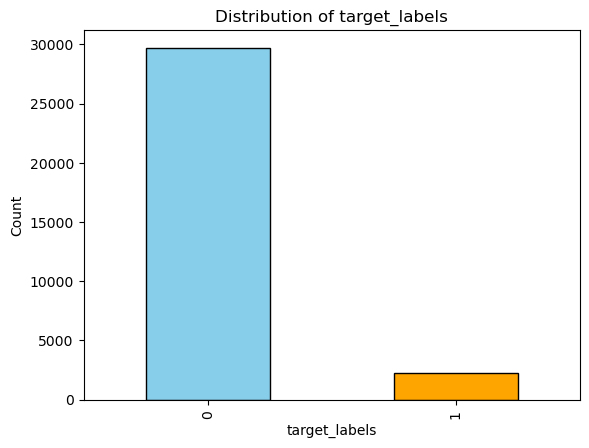

In [8]:
# Distribution of tartget_labels
print(train["label"].value_counts())  # Count of tartget_labels (1) and (0)
print((train["label"].value_counts() / train["label"].count()) * 100)  # Percentage distribution

# Plotting the distribution as a bar chart
train["label"].value_counts().plot(kind="bar", color=['skyblue', 'orange'], edgecolor='black')

# Adding labels and title for the plot
plt.title('Distribution of target_labels')
plt.xlabel('target_labels')
plt.ylabel('Count')

# Show the plot
plt.show()

# Pre-Processing

In [9]:
import emoji
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
import ast
from nltk.corpus import stopwords
import string
import re

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Load contractions and slang dictionaries
with open('contractions.txt', 'r') as file:
    content = file.read()
content = '{' + content.strip().rstrip(',') + '}'
contractions_dict = ast.literal_eval(content)

slang_dict = {}
with open('slang.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('=')
        if len(parts) == 2:
            slang_dict[parts[0].strip()] = parts[1].strip()

# Create an instance of the PorterStemmer
ps = PorterStemmer()

def preprocess_text(df, text_column="tweet"):
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Apply all preprocessing steps
    df[text_column] = df[text_column].str.lower().apply(encode_emojis)
    df[text_column] = df[text_column].apply(remove_misencoded_chars)
    df[text_column] = df[text_column].apply(contra_conv)
    df[text_column] = df[text_column].apply(basic_preprocess)
    df[text_column] = df[text_column].apply(remove_punc)
    df[text_column] = df[text_column].apply(chat_conv)
    df[text_column] = df[text_column].apply(remove_stopwords)
    df[text_column] = df[text_column].apply(stem_words)
    
    return df

def remove_punc(text):
    """
    Remove punctuation from text while preserving hashtags.
    Why? We will be using it as a feature!
    """
    if isinstance(text, str):
        # Create a modified punctuation string without #
        punct = string.punctuation.replace('#', '')
        
        # Remove all punctuation except #
        return text.translate(str.maketrans('', '', punct))
    return text

def encode_emojis(text):
    """Convert emojis to text representation"""
    if isinstance(text, str):
        emojis = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', text)
        for emoji_ in emojis:
            text = text.replace(emoji_, emoji.demojize(emoji_))
        return text
    return text

def remove_misencoded_chars(text):
    """Remove misencoded characters from text"""
    if isinstance(text, str):
        cleaned_text = text.replace('ð', '')
        cleaned_text = re.sub(r'[^\x00-\x7F]+', '', cleaned_text)
        return cleaned_text
    return text

def contra_conv(text):
    """Convert contractions to their expanded form"""
    if isinstance(text, str):
        new_text = [contractions_dict.get(w, w) for w in text.split()]
        return " ".join(new_text)
    return text

def basic_preprocess(text):
    """Perform basic text preprocessing"""
    if isinstance(text, str):
        # adjusting specific symbols
        text = text.replace('%', ' percent').replace('$', ' dollar ').replace('₹', ' rupee ').replace('€', ' euro ')
        # Removing numbers
        text = re.sub(r'\d+', '', text)
        # Removing mentions
        text = re.sub(r'@[\w]*', '', text)
        # Removing HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
        return text.strip()
    return text

def chat_conv(text):
    """Convert chat/slang words to their standard form"""
    if isinstance(text, str):
        new_text = [slang_dict.get(w.upper(), w) for w in text.split()]
        return " ".join(new_text)
    return text

def remove_stopwords(text):
    """Remove stopwords from text"""
    if isinstance(text, str):
        words = [word for word in text.split() if word.lower() not in stop_words]
        return " ".join(words)
    return text

def stem_words(text):
    """Apply stemming to words in text"""
    if isinstance(text, str):
        return " ".join([ps.stem(word) for word in text.split()])
    return text

In [10]:
# pre-processing
train = preprocess_text(train)
test = preprocess_text(test)

In [11]:
# processed data
train.sample(5)

,id,label,tweet
15093,15094,0,tysvm #monday
1214,1215,1,also #keyboard type caus coopt terrorist reg s...
3033,3034,0,greatest #dad simpl #dad thank #dad everyth #f...
3774,3775,0,#model love take time ur
12273,12274,0,#father #day father


# Feature-Engineering

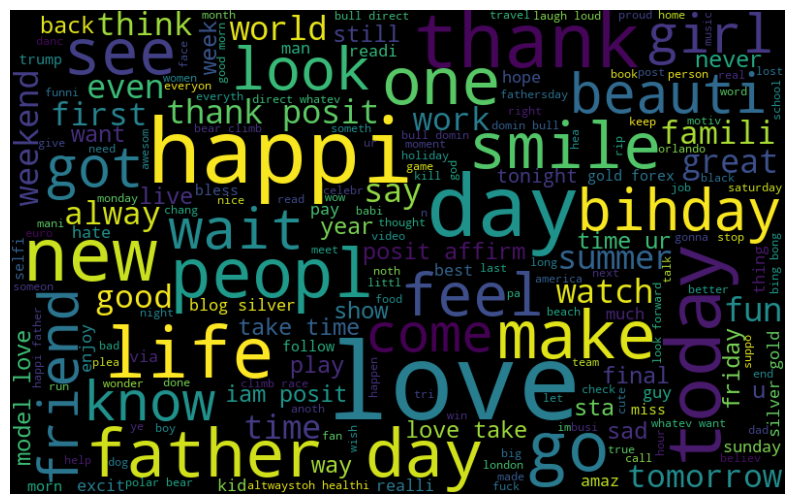

In [12]:
# common words used in the tweets
combi = pd.concat([train, test])
all_words = ' '.join([text for text in combi['tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

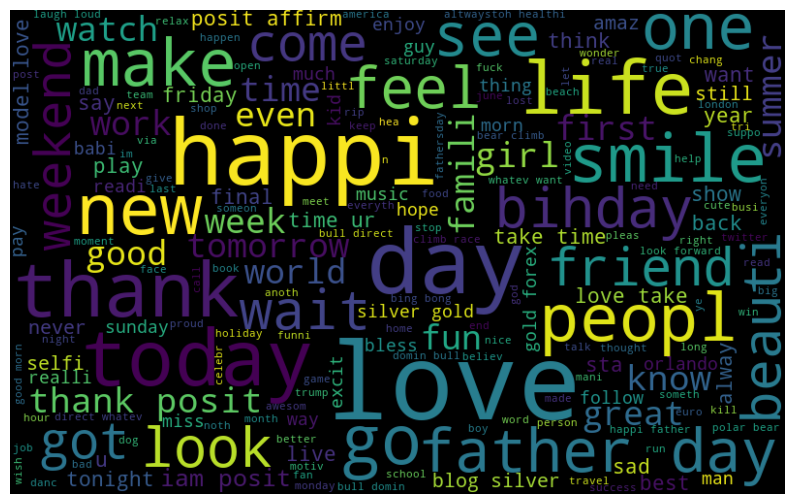

In [13]:
# common words used in the non racist/sexist tweets
normal_words =' '.join([text for text in combi['tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

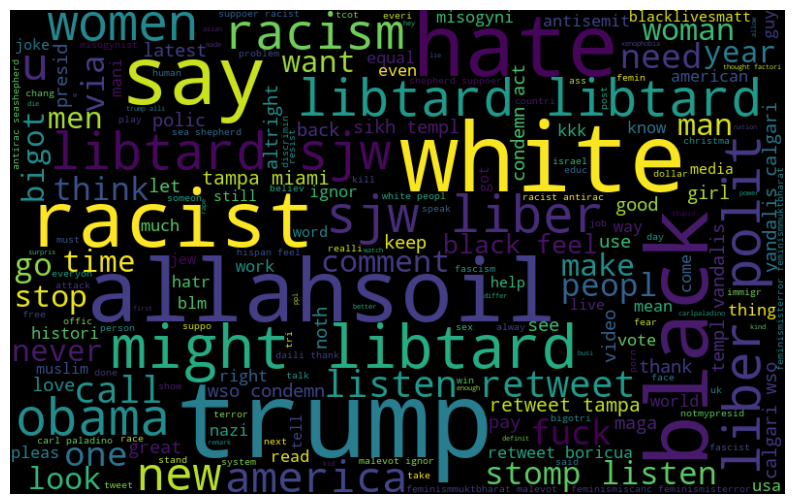

In [14]:
# common words used in the racist/sexist tweets
normal_words =' '.join([text for text in combi['tweet'][combi['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [15]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

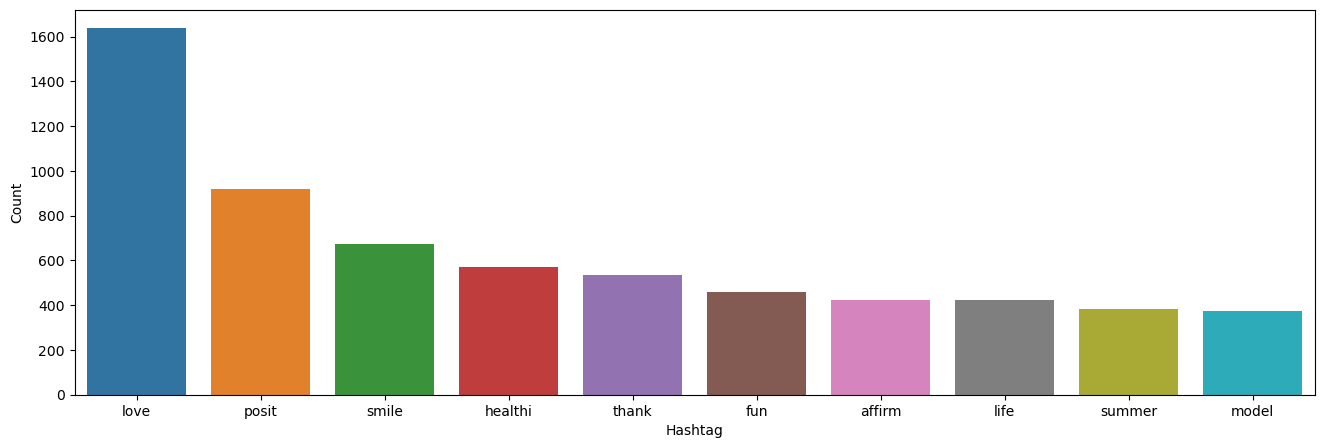

In [16]:
# Understand the trends in non racist/sexist tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

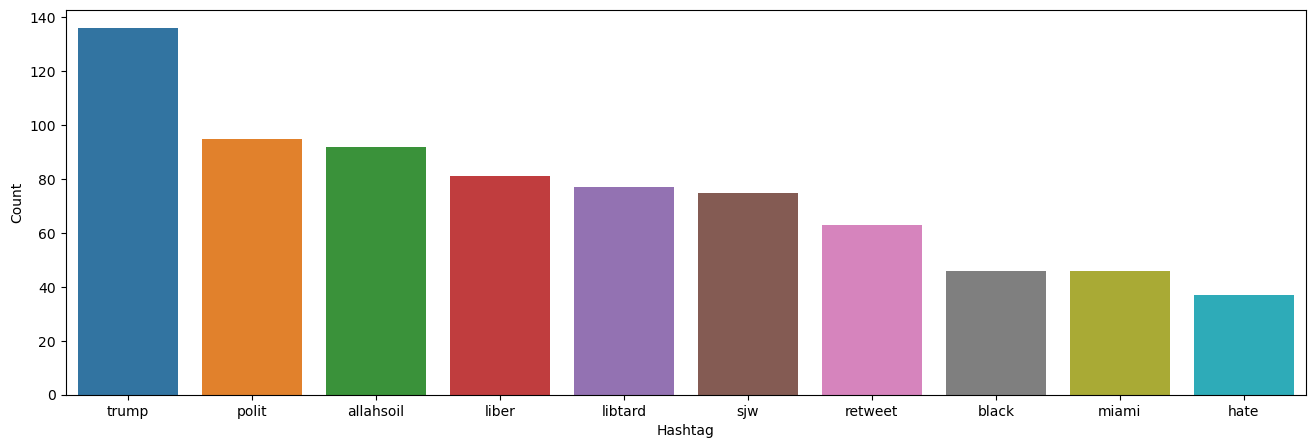

In [17]:
# Understand the trends in racist/sexist tweets
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000)

# Fit the vectorizer on the combined dataset of tweets (training + testing)
bow_vectorizer = bow_vectorizer.fit(combi['tweet'])

# Transform the training and test datasets into the bag-of-words feature matrix
bow_train = bow_vectorizer.transform(train['tweet']).toarray()
bow_test = bow_vectorizer.transform(test['tweet']).toarray()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)

# Fit the vectorizer on the combined dataset of tweets (training + testing)
tfidf_vectorizer = tfidf_vectorizer.fit(combi['tweet'])

# Transform the training and test datasets into the tfidf feature matrix
tfidf_train = tfidf_vectorizer.transform(train['tweet']).toarray()
tfidf_test = tfidf_vectorizer.transform(test['tweet']).toarray()

# Model Training & Evaluation

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow_train, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # If prediction is >= 0.3, mark as 1
prediction_int = prediction_int.astype(int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.543657331136738

In [35]:
xtrain_tfidf = tfidf_train[ytrain.index] # use the same split as bow
xvalid_tfidf = tfidf_train[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_score(yvalid, prediction_int)

0.5588752196836555